Foundations for Brent Oil Change Point Analysis

# Task 1: 
**Objective:**  
Establish a strong foundation for Bayesian change point modeling by:
- Understanding the Brent oil price data
- Conducting exploratory data analysis (EDA)
- Compiling key events
- Defining workflow, assumptions, and communication strategy

**Deliverables:**
1. EDA and workflow documentation
2. `events.csv` with 10–15 key events
3. Markdown cells explaining assumptions, limitations, and insights


1. Import Libraries

In [2]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tests
from statsmodels.tsa.stattools import adfuller

# Plot style
sns.set(style="whitegrid")


2. Load and Inspect Data

In [3]:
# Load raw Brent Oil prices
data_path = "../data/raw/BrentOilPrices.csv"
brent_df = pd.read_csv(data_path)

# Quick inspection
print(brent_df.head())
print(brent_df.info())

# Convert Date to datetime
brent_df['Date'] = pd.to_datetime(brent_df['Date'], dayfirst=True)

# Sort by date
brent_df = brent_df.sort_values('Date').reset_index(drop=True)

# Preview cleaned data
brent_df.head()


        Date  Price
0  20-May-87  18.63
1  21-May-87  18.45
2  22-May-87  18.55
3  25-May-87  18.60
4  26-May-87  18.63
<class 'pandas.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   str    
 1   Price   9011 non-null   float64
dtypes: float64(1), str(1)
memory usage: 140.9 KB
None


C:\Users\derej\AppData\Local\Temp\ipykernel_7884\592110358.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  brent_df['Date'] = pd.to_datetime(brent_df['Date'], dayfirst=True)


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


3. Plot Raw Prices

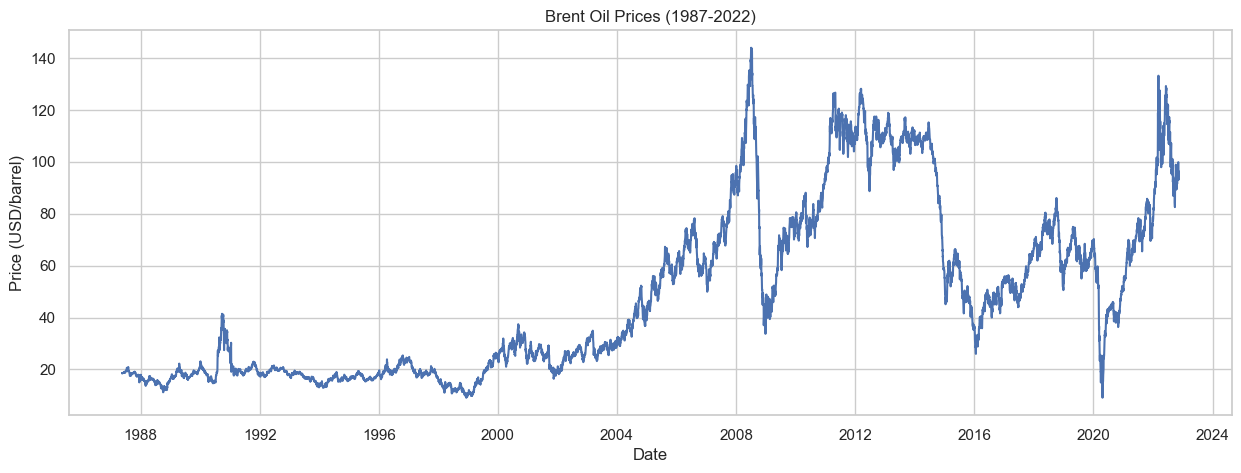

In [4]:
plt.figure(figsize=(15,5))
sns.lineplot(x='Date', y='Price', data=brent_df)
plt.title("Brent Oil Prices (1987-2022)")
plt.xlabel("Date")
plt.ylabel("Price (USD/barrel)")
plt.show()


4. Compute Log Returns

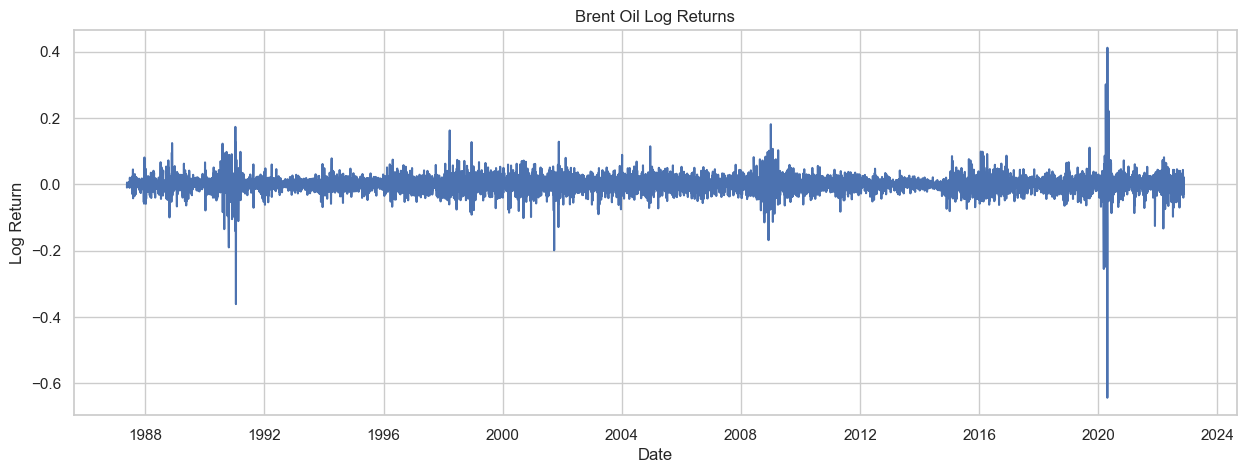

In [5]:
# Compute daily log returns for stationarity
brent_df['LogReturn'] = np.log(brent_df['Price']).diff()
brent_df = brent_df.dropna()

# Plot log returns
plt.figure(figsize=(15,5))
sns.lineplot(x='Date', y='LogReturn', data=brent_df)
plt.title("Brent Oil Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()


5. Stationarity Test (ADF Test)

In [6]:
result = adfuller(brent_df['LogReturn'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("Reject null hypothesis → Log returns are stationary")
else:
    print("Fail to reject null → Series is non-stationary")


ADF Statistic: -16.427113494485894
p-value: 2.4985801611428892e-29
Reject null hypothesis → Log returns are stationary


6. Compile Key Events (events.csv)

In [8]:
# Identify extreme shocks using statistical thresholding
shock_threshold = brent_df['LogReturn'].abs().quantile(0.99)

shock_events = brent_df.loc[
    brent_df['LogReturn'].abs() > shock_threshold,
    ['Date', 'LogReturn']
].copy()

shock_events['ShockType'] = np.where(
    shock_events['LogReturn'] > 0, 'Positive Shock', 'Negative Shock'
)

shock_events.head()


,Date,LogReturn,ShockType
153,1987-12-22,0.081041,Positive Shock
366,1988-10-24,-0.099771,Negative Shock
387,1988-11-22,0.095835,Positive Shock
390,1988-11-25,0.124438,Positive Shock
818,1990-08-02,0.110116,Positive Shock


In [9]:
# Keep only the largest shocks per year
shock_events['Year'] = shock_events['Date'].dt.year

major_shocks = (
    shock_events
    .assign(abs_return=lambda x: x['LogReturn'].abs())
    .sort_values('abs_return', ascending=False)
    .groupby('Year')
    .head(1)
    .sort_values('Date')
    .head(15)
)

major_shocks


,Date,LogReturn,ShockType,Year,abs_return
153,1987-12-22,0.081041,Positive Shock,1987,0.081041
390,1988-11-25,0.124438,Positive Shock,1988,0.124438
875,1990-10-22,-0.190184,Negative Shock,1990,0.190184
936,1991-01-17,-0.361214,Negative Shock,1991,0.361214
2754,1998-03-23,0.162559,Positive Shock,1998,0.162559
3376,2000-09-12,-0.101841,Negative Shock,2000,0.101841
3641,2001-09-24,-0.198906,Negative Shock,2001,0.198906
4021,2003-03-21,-0.090003,Negative Shock,2003,0.090003
4471,2004-12-15,0.114688,Positive Shock,2004,0.114688
5481,2008-12-05,-0.168320,Negative Shock,2008,0.168320


In [10]:
events_df = major_shocks[['Date', 'ShockType', 'LogReturn']].copy()
events_df['Event_Description'] = "Statistically detected structural shock"
events_df['Category'] = "Market Shock"

events_df.to_csv("../data/processed/detected_events.csv", index=False)
events_df


,Date,ShockType,LogReturn,Event_Description,Category
153,1987-12-22,Positive Shock,0.081041,Statistically detected structural shock,Market Shock
390,1988-11-25,Positive Shock,0.124438,Statistically detected structural shock,Market Shock
875,1990-10-22,Negative Shock,-0.190184,Statistically detected structural shock,Market Shock
936,1991-01-17,Negative Shock,-0.361214,Statistically detected structural shock,Market Shock
2754,1998-03-23,Positive Shock,0.162559,Statistically detected structural shock,Market Shock
3376,2000-09-12,Negative Shock,-0.101841,Statistically detected structural shock,Market Shock
3641,2001-09-24,Negative Shock,-0.198906,Statistically detected structural shock,Market Shock
4021,2003-03-21,Negative Shock,-0.090003,Statistically detected structural shock,Market Shock
4471,2004-12-15,Positive Shock,0.114688,Statistically detected structural shock,Market Shock
5481,2008-12-05,Negative Shock,-0.168320,Statistically detected structural shock,Market Shock


7. Proposed Analysis Workflow, Assumptions, and Communication Plan



## 1. Proposed Analysis Workflow

1. **Data Ingestion & Cleaning**
   - Load `BrentOilPrices.csv` from `data/raw`
   - Convert dates to datetime format, sort chronologically
   - Compute log returns for stationarity analysis

2. **Exploratory Data Analysis (EDA)**
   - Visualize trends, detect periods of high volatility
   - Check stationarity using ADF test
   - Identify outliers and extreme movements for candidate change points

3. **Data-Driven Event Detection**
   - Detect major statistical shocks in log returns (top 1% absolute values)
   - Select the largest shock per year to compile 10–15 key events
   - Export results to `data/processed/detected_events.csv`

4. **Bayesian Change Point Modeling**
   - Implement in `modelling.ipynb` using PyMC
   - Define switch points, before/after parameters, likelihood, and sampler
   - Run MCMC to estimate posterior distributions of change points

5. **Association with Real-World Events**
   - Compare detected change points with known geopolitical, economic, and policy events
   - Formulate hypotheses for potential causes without claiming causality

6. **Visualization & Dashboard**
   - Create interactive dashboard to explore price trends, detected shocks, and associated events
   - Include filters, date selectors, and event highlight functionality

7. **Reporting & Communication**
   - Generate clear, actionable insights for stakeholders
   - Include visualizations, interpretations, and probabilistic statements of impact

---

## 2. Assumptions & Limitations

### Assumptions
- Daily Brent oil prices are accurate and representative of market behavior.
- Only major statistical shocks are considered as candidate events.
- Statistical correlation may suggest a relationship, but **does not establish causation**.
- Selecting one major shock per year captures significant market events while avoiding noise.

### Limitations
- External macroeconomic factors (currency fluctuations, GDP, inflation) are not included.
- Bayesian change point model results are sensitive to prior selection and model assumptions.
- Event dates are approximate and may not perfectly align with actual market reactions.
- Only historical data up to 2022 is considered; future applicability may vary.
- Using daily prices may miss intra-day events or short-lived shocks.

---

## 3. Stakeholders & Communication Plan

| Stakeholder    | Communication Format                              | Key Deliverables                                     |
|----------------|--------------------------------------------------|-----------------------------------------------------|
| Investors      | Interactive dashboard + PDF insights            | Top events, price impact, and trends               |
| Policymakers   | Executive summary + PDF report                  | High-level strategic implications                  |
| Analysts       | Jupyter notebook + dashboard                     | Full dataset, detection method, and model results  |

---

## 4. Task 1 Deliverables

1. `foundations.ipynb` → EDA, data cleaning, shock detection, and workflow documentation
2. `data/processed/detected_events.csv` → 10–15 statistically detected major events
3. PDF report: `Task1_Bayesian_ChangePoint_Analysis_and_Event_Insight_Report.pdf`
   - Includes workflow explanation, assumptions, limitations, and stakeholder plan
